# Bicubic Interpolation

Classical method used in astronomy for super-resolution through bicubic interpolation


# Synthetic Data Tests

## Generating the Data

To test the different super-resolution methods, synthetic data was generated by starting with a "high-resolution" Airy's disk as seen below. The image was then subject to the following to generate synthetic low-resolution frames:

1. Motion
2. Blur
3. Downsample
4. Random Noise

Using the low-resolution images, super-resolution algorithms were applied to reconstruct the original image. The reconstruction effort and original image are compared to quantify each algorithms performance. For the case of this summary, the starting high-resolution image will have the dimensions of 100x100, and the low-resolution frames 25x25. The goal is to increase the pixel resolution by 4x.

In [1]:
# Link the repositories used throughout this notebook
import sys
sys.path.insert(0, "../src/")
sys.path.insert(0, "../orex/")

Synthetic high-resolution image (100x100)


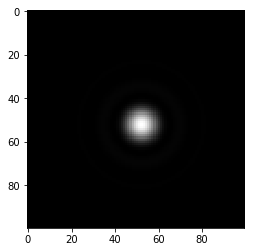

Sample of generated low-resolution frame (25x25)


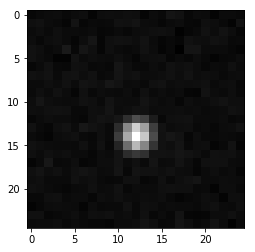

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from observation_model import ObservationModel
from astropy.convolution import AiryDisk2DKernel

# Starting resolution of 100x100
im = np.array(AiryDisk2DKernel(13))
im = im[0:100, 0:100]

print("Synthetic high-resolution image (100x100)")
plt.imshow(im, cmap='gray')
plt.show()

# Arbitrary PSF
psf = np.ones((3, 3)) / 9

# 100 low-resolution frames (25x25) are generated
camera = ObservationModel(im, n=100, psf=psf, downsample_factor=4, translation_range=(-5, 5),
                          rotation_range=(0, 0), noise_scale=0.0001)

low_res = camera.low_res_images

print("Sample of generated low-resolution frame (25x25)")
plt.imshow(low_res[0], cmap='gray')
plt.show()

## Bicubic Reconstruction Effort

The bicubic interpolation for super-resolution is very simple/straight-forward

1. Upsample each low-resolution frame with bicubic interpolation
1. Register the images
2. Take the average 

d:\python\lib\site-packages\skimage\measure\simple_metrics.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


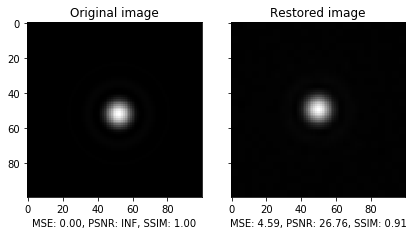

In [3]:
from observation_model import normalize
from bicubic_interpolation import bicubic_restore, compare

restored = bicubic_restore(low_res, downsample_factor=4)

# Get both on the same scale for comparisons
im = normalize(im, 0, 1)
restored = normalize(restored, 0, 1)

compare(im, restored)

# NavCam Data Results

Example application on NavCam1 images with upsample factor of 8x. 

### Process Overview

1. Divide the NavCam images up into sections that are reasonably isoplanatic so that the PSF isn’t dramatically changing within a section.  A 9 x 5 grid is a logical place to start.

2. Upsample the star images within a section using bi-cubic interpolation with the cubic=-0.5 until unphysical artifacts creep into the results.

3. Normalize the stars by using their apparent magnitudes to account for different star intensities

4. Align the star images by placing the centroid of each star in the center of the image

5. Stack the aligned star images in each section on top of each other and take the average to generate a high-resolution representation of the PSF at each of the 45 grids.

6. Output the 45 high-resolution sections as a 9x5 composite image to see how the PSF changes across the image 

In [4]:
from scipy import misc
from load_tagcam import load_tagcam
from extract_stars import extract_by_section
from observation_model import normalize
from registration import centroid_align

# Load in all of the NavCam1 images
im_dir1 = "D:/alkiek_winter_2017/repos/data/navcam1/DAY14"
im_dir2 = "D:/alkiek_winter_2017/repos/data/navcam1/DAY101"
im_dir3 = "D:/alkiek_winter_2017/repos/data/navcam1/DAY107"
images = load_tagcam(directories=[im_dir1, im_dir2, im_dir3]).images

print("Total number of images used: {0}".format(len(images)))

# Cutoff the last two columns of pixels so that the images divide evenly
images = [im[0:1940, :] for im in images]

# Divide the images into 9x5 grids and get the stars from each section across all images
shape = (9, 5)
n = 2
section_stars = extract_by_section(images, shape, n, size=9)

print("Stars extracted per section: {0}".format(n))
star_count = np.prod(shape) * n * len(images)
print("Total stars extracted across all images: {0}".format(star_count))

# Dictionary of lists to store the upsampled stars
keys = np.arange(np.prod(shape))
upsampled_stars = {key: [] for key in keys}

# Upsample the stars within each section using bicubic interpolation and align them using their centroid
for index, stars in section_stars.items():
    resized_stars = [misc.imresize(star, 800, 'bicubic') for star in stars]
    stars = centroid_align(resized_stars)
    upsampled_stars[index]= np.mean(stars, axis=0)

Total number of images used: 56
Stars extracted per section: 2
Total stars extracted across all images: 5040


### Notes

* The images are normalized before being read in during the band correction.
* Extract stars function looks for the brightest regions in a given function. If the *n* given to the program is greater than the actual number of stars in the section it can throw off the end result. Its safest to stick with a low *n* 


Example Single Section PSF


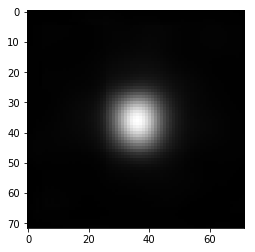

Composite of Spatially-variant PSF


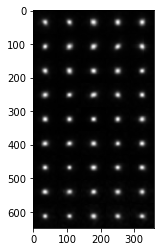

In [5]:
# Stitch together a composite image. TODO: Rewrite
def composite_psf(stars, shape):
    y = shape[1]
    rows = []
    for i in range(0, len(stars), y):
        row = np.hstack(stars[i: i+y])
        rows.append(row)

    return np.vstack(rows)

stars = list(upsampled_stars.values()) 

print("Example Single Section PSF")
plt.imshow(stars[3], cmap='gray')
plt.show()

print("Composite of Spatially-variant PSF")
psf = composite_psf(stars, shape=(9, 5))
plt.imsave('psf.jpg', psf, cmap='gray')
plt.imshow(psf, cmap='gray')
plt.show()

## Final Thoughts

